# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [ ]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48 kB 5.6 MB/s 


In [ ]:
import FinanceDataReader as fdr

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [ ]:
df_krx = fdr.StockListing("KRX")

df_krx.head(10)

len(df_krx)

tiker_list = df_krx[['Symbol','Name']]
print(tiker_list)

print("\n원하는 종목을 입력하시오")
a = input()

Stock_Name = tiker_list.loc[tiker_list['Name'] == a]
print(Stock_Name,"\n")

symbol_Number = Stock_Name.Symbol

sn = symbol_Number.iloc[0]
print(sn)

Stock = fdr.DataReader(sn)

      Symbol             Name
0     060310               3S
1     095570           AJ네트웍스
2     006840            AK홀딩스
3     054620           APS홀딩스
4     265520            AP시스템
...      ...              ...
7617  003280             흥아해운
7618  037440               희림
7619  419890  히어로즈 단기채권ESG액티브
7620  429870    히어로즈 리츠이지스액티브
7621  238490               힘스

[7622 rows x 2 columns]

원하는 종목을 입력하시오
3S
   Symbol Name
0  060310   3S 

060310


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


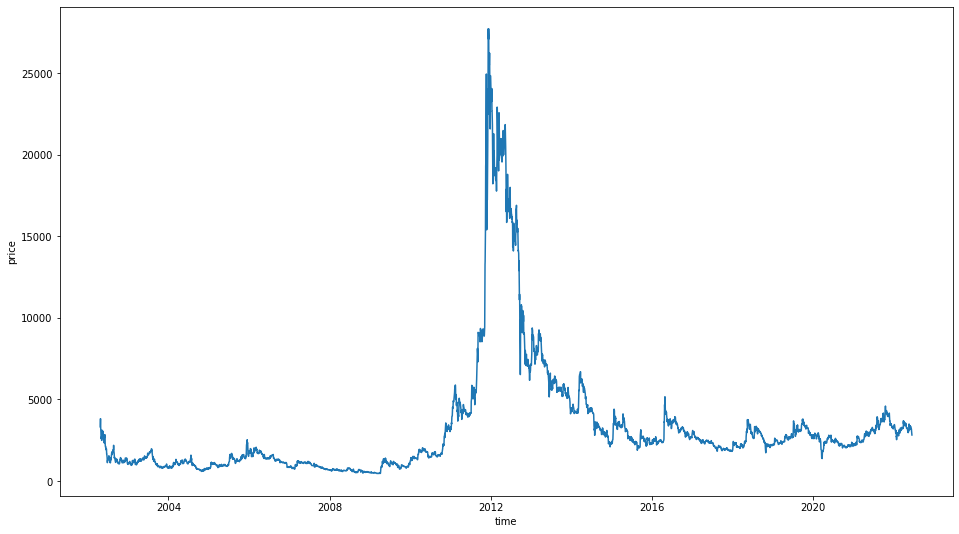

In [ ]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=Stock['Close'], x=Stock.index)
plt.xlabel('time')
plt.ylabel('price')

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(Stock[scale_cols])
scaled

array([[0.10156001, 0.0991578 , 0.11080343, 0.10501228, 0.01568723],
       [0.11344582, 0.11295186, 0.11334179, 0.1195688 , 0.02024833],
       [0.13134529, 0.12834021, 0.10895735, 0.12341877, 0.11060686],
       ...,
       [0.09338852, 0.09288462, 0.09826545, 0.0934624 , 0.01418961],
       [0.08542927, 0.08768586, 0.09326564, 0.08961244, 0.0139061 ],
       [0.08613676, 0.08560635, 0.08903504, 0.08667913, 0.01005425]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [ ]:
x_train.shape, y_train.shape

((3984, 4), (3984,))

In [ ]:
x_test.shape, y_test.shape

((997, 4), (997,))

In [ ]:
x_train

,Open,High,Low,Volume
0,0.101560,0.099158,0.110803,0.015687
1,0.113446,0.112952,0.113342,0.020248
2,0.131345,0.128340,0.108957,0.110607
3,0.116240,0.116626,0.112534,0.025340
4,0.089250,0.093127,0.097073,0.020056
...,...,...,...,...
3979,0.103824,0.108481,0.111919,0.023605
3980,0.108776,0.119918,0.116149,0.025476
3981,0.115321,0.120438,0.122880,0.019062
3982,0.110191,0.114026,0.115957,0.014094


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [ ]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    124/Unknown - 18s 6ms/step - loss: 0.0028 - mse: 0.0055
Epoch 1: val_loss improved from inf to 0.00002, saving model to tmp/ckeckpointer.ckpt
124/124 [==============================] - 19s 15ms/step - loss: 0.0028 - mse: 0.0055 - val_loss: 2.2241e-05 - val_mse: 4.4481e-05
Epoch 2/50
114/124 [==========================>...] - ETA: 0s - loss: 3.0657e-04 - mse: 6.1314e-04
Epoch 2: val_loss did not improve from 0.00002
124/124 [==============================] - 1s 8ms/step - loss: 3.0252e-04 - mse: 6.0505e-04 - val_loss: 2.2369e-05 - val_mse: 4.4737e-05
Epoch 3/50
124/124 [==============================] - ETA: 0s - loss: 2.8543e-04 - mse: 5.7087e-04
Epoch 3: val_loss did not improve from 0.00002
124/124 [==============================] - 1s 8ms/step - loss: 2.8543e-04 - mse: 5.7087e-04 - val_loss: 3.1790e-05 - val_mse: 6.3579e-05
Epoch 4/50
123/124 [============================>.] - ETA: 0s - loss: 2.5791e-04 - mse: 5.1582e-04
Epoch 4: val_loss did not improve from 0.00002


저장한 ModelCheckpoint 를 로드합니다.

In [ ]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [ ]:
pred = model.predict(test_data)

In [ ]:
#pred.shape

(977, 1)

In [ ]:
sliced_pred = pred[-61:]

fluctuation_len = len(sliced_pred)
fluctuation_len

In [ ]:
fluctuation_arr = np.zeros(shape = (fluctuation_len) -1)

for i in range(61):
    if (i == 0) :
        continue
    else :
        pre_stock_price = sliced_pred[i - 1]
        cur_stock_price = sliced_pred[i]
        fluctuation_arr[i-1] = (cur_stock_price - pre_stock_price) / pre_stock_price * 100

In [ ]:
fluctuation_arr

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

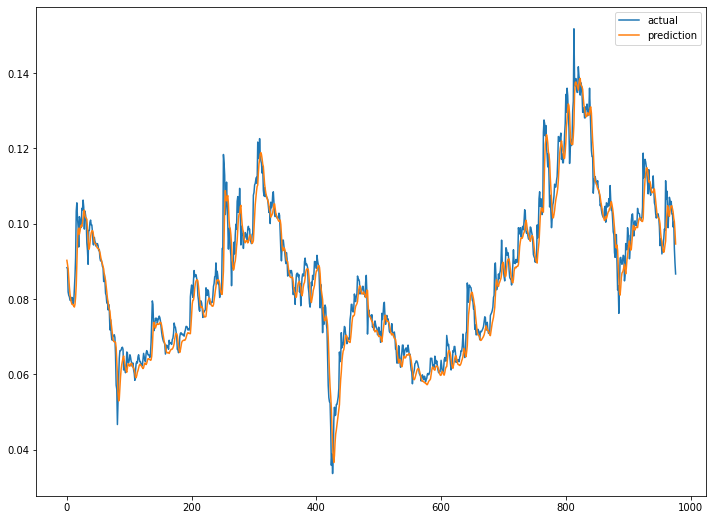

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [ ]:
plt.plot(fluctuation_arr, label='fluctuation')
plt.legend()
plt.show()